# **Malaria Infected Image Classification**
#### **Submitted By:** Luke Chugh

#### **Date:** 04/03/2022

#### **Importing Necessary Dependancies**

In [ ]:
import os
import cv2
import shutil
import numpy as np
import seaborn as sns
from tensorflow import keras
from keras import optimizers
from google.colab import drive
from keras import regularizers
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.models import Sequential
from sklearn.metrics import auc, roc_curve
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG19 as vgg
from tensorflow.keras.applications import InceptionV3 as inception 
from tensorflow.keras.applications import MobileNetV2 as mobilenet
from sklearn.model_selection import cross_validate, train_test_split
from tensorflow.keras.applications.resnet50 import ResNet50 as resnet
from tensorflow.keras.applications.xception import Xception as xception
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation

#### **Pre-Processing the data to be suitable for Model Building:**
Mounting my google drive:

In [ ]:
drive.mount('/content/drive')
%cd '/content/drive/My Drive/Colab Notebooks/Assignments/ML/malaria_data/'

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Assignments/ML/malaria_data


**Preparing Images and Labels:**

The tree of the folder is as follows:

The name of the root directory is named "malaria_data" which contains 2 folders "C0" and "C1" (which indicates Class 0 and Class 1) where C0 is "Uninfected" and C1 is "Parasited" set of images respectively. I have done this just to make the coding part more convinient and easy for me

In [ ]:
root_path = '/content/drive/My Drive/Colab Notebooks/Assignments/ML/malaria_data/'

images = []
labels = []
shape = (128,128)
classes = 2

for i in range(0, classes):
  folder_name = root_path + 'C' + str(i) + '/'
  path_list = os.listdir(folder_name)
  for j in path_list:
    if '.png'  in j:
      labels.append(i)
      img = cv2.imread(os.path.join(folder_name,j))
      img = cv2.resize(img,shape)
      images.append(img)

**Preparing Test and Train datasets:**

In [ ]:
images_shuffled, labels_shuffled = shuffle(images, labels, random_state=0)
x, y  = images_shuffled[:9000], labels_shuffled[:9000]
X = np.array(x)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=50)
X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

#### **Exploring the dataset to understand it's characteristics:**

Text(0, 0.5, 'No. of Images')

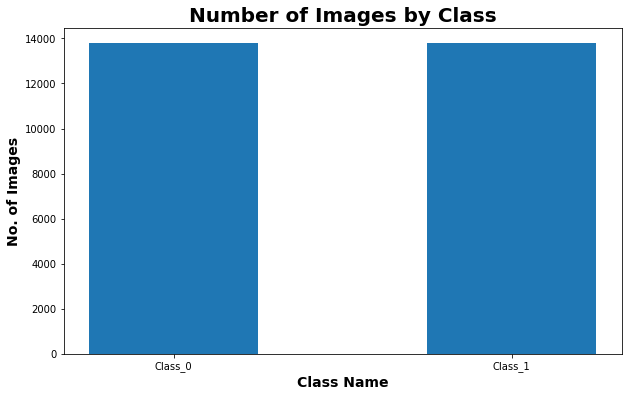

In [ ]:
class_0 = '/content/drive/My Drive/Colab Notebooks/Assignments/ML/malaria_data/C0'
class_1 = '/content/drive/My Drive/Colab Notebooks/Assignments/ML/malaria_data/C1'
number_classes = {'Class_0': len(os.listdir(class_0)), 'Class_1': len(os.listdir(class_1)) }
plt.figure(figsize=(10,6))
plt.bar(number_classes.keys(), number_classes.values(), width = .5)
plt.title("Number of Images by Class", fontsize = 20, fontweight = 'bold')
plt.xlabel('Class Name', fontsize = 14, fontweight = 'bold')
plt.ylabel('No. of Images', fontsize = 14, fontweight = 'bold')

As we can explicitly see, both the classes have equall number of images i.e. 13799 each. 

Let's plot some of these Images and see their characteristics

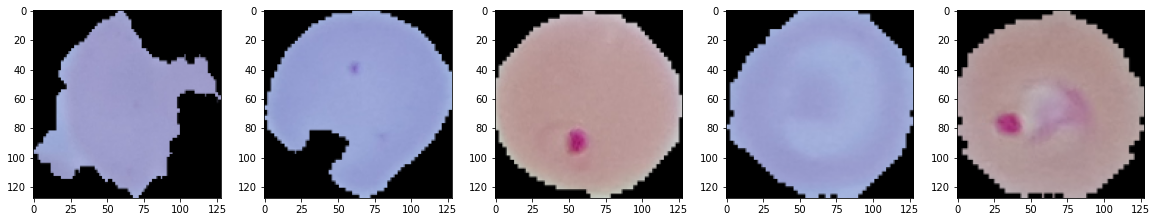

In [ ]:
plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.imshow(images_shuffled[i])

The Uninfected images are bluish in color and have no spot on them. Whereas, on the contrary Parasited Images are peach in color and have a pink spot on them

#### **Model Building and Fine Tuning:**

In [ ]:
def performance_metrics(x):

  ## RE-CREATING PRETRAINED CNN MODEL:
  model = Sequential()
  model.add( x(include_top=False, pooling='avg', weights='imagenet', input_shape=(128, 128, 3), classes=2))
  model.add(Flatten())
  # ADDED A BatchNormalisation LAYER WITH SIGMOID ACTIVATION FUNCTION
  model.add(BatchNormalization())                   
  model.add(Activation('sigmoid'))
  # ADDED A DROUPOUT LAYER WITH DROPOUT RATE = 30%
  model.add(Dropout(0.3))  
  # ADDED 2 DENSE LAYERS WITH SCLAED EXPONENTIAL LINEAR ACTIVATION FUNCTION                         
  model.add(Dense(256,activation='selu'))           
  model.add(Dense(64,activation='selu'))
  # ADDED AN OUTPUT LAYER OF 1 UNIT WITH SIGMOID ACTIVATION FUNCTION
  model.add(Dense(1,activation = 'sigmoid'))       
  # SETTING ALL LAYERS EXCEPT LAST 10 LAYERS TO BE NON-TRAINABLE TO KEEP "Imagenet" WEIGHTS AND BIASES 
  for layer in model.layers[:-10]:                  
    layer.trainable=False
  early_stop = EarlyStopping(monitor='val_loss', patience=2)
  # ADDING NADAM OPTIMIZER
  opt = Nadam(learning_rate=0.00005, beta_1=0.9, beta_2=0.999, epsilon=1e-07)                            
  model.compile(optimizer= opt, loss='binary_crossentropy', metrics=['accuracy'])
  model_history = model.fit(X_train,y_train, validation_split = 0.2,epochs=3, batch_size=100, verbose=1)

  ## MAKING PREDICTIONS ON THE TEST SET | CALCULATING EVALUATION METRICS: PRECISION, RECALL, AUC, ROC, F1:
  y_pred_keras = model.predict(X_test).ravel()
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
  precision, recall, thresholds = precision_recall_curve(y_test, y_pred_keras)
  auc_keras = auc(fpr_keras, tpr_keras)
  
  ## CONVERTING PREDICTIONS TO 0's AND 1's | PRINTING CLASSIFICATION REPORT:
  y_pred = []
  for item in y_pred_keras:
    if item > 0.5:
      item = 1
    else:
      item = 0
    y_pred.append(item)
  print('\nClassification Report:')
  print(classification_report(y_test, y_pred))

  ## PLOTTING PRECISION RECALL CURVE:
  plt.figure(figsize=(12,8))
  plt.plot(recall, precision, label='Keras (AUC = {:.3f})'.format(auc_keras))
  plt.xlabel('RECALL', fontsize = 14, fontweight = 'bold')
  plt.ylabel('PRECISION', fontsize = 14, fontweight = 'bold')
  plt.title('PRECISION-RECALL CURVE', fontsize = 20, fontweight = 'bold')
  plt.legend(loc='best')

  ## PLOTTING ROC CURVE WITH AUC SCORE:
  plt.figure(figsize=(12,8))
  plt.plot(fpr_keras, tpr_keras, label='Keras (AUC = {:.3f})'.format(auc_keras))
  plt.xlabel('False positive rate', fontsize = 14, fontweight = 'bold')
  plt.ylabel('True positive rate', fontsize = 14, fontweight = 'bold')
  plt.title('ROC curve', fontsize = 20, fontweight = 'bold')
  plt.legend(loc='best')

  # PLOTTING TRAINING ACCURACY AND VALIDATION ACCURACY:
  plt.figure(figsize=(12,8))
  plt.plot(model_history.history['accuracy'], label = 'training', marker = '*', linewidth = 3)
  plt.plot(model_history.history['val_accuracy'], label = 'validation', marker = 'o', linewidth = 3)
  plt.title('Training Accuracy vs Validation Accuracy', fontsize = 20, fontweight = 'bold')
  plt.xlabel('Epochs', fontsize = 14, fontweight = 'bold')
  plt.ylabel('Accuracy', fontsize = 14, fontweight = 'bold')
  plt.legend(fontsize = 'x-large')

  # PLOTTING TRAINING LOSS AND VALIDATION LOSS:
  plt.figure(figsize=(12,8))
  plt.plot(model_history.history['loss'], label = 'training', marker = '*', linewidth = 3)
  plt.plot(model_history.history['val_loss'], label = 'validation', marker = 'o', linewidth = 3)
  plt.title('Training Loss vs Validation Loss', fontsize = 20, fontweight = 'bold')
  plt.xlabel('Epochs', fontsize = 14, fontweight = 'bold')
  plt.ylabel('Loss', fontsize = 14, fontweight = 'bold')
  plt.legend(fontsize = 'x-large')
  
  return print()

#### **Model Evaluation and Comparision:**

#### ResNet-50

94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/3
58/58 [==============================] - 1353s 23s/step - loss: 0.2597 - accuracy: 0.8882 - val_loss: 0.1343 - val_accuracy: 0.9528
Epoch 2/3
58/58 [==============================] - 1327s 23s/step - loss: 0.0829 - accuracy: 0.9714 - val_loss: 0.1691 - val_accuracy: 0.9444
Epoch 3/3
58/58 [==============================] - 1319s 23s/step - loss: 0.0268 - accuracy: 0.9905 - val_loss: 0.1481 - val_accuracy: 0.9583

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       899
           1       0.98      0.95      0.97       901

    accuracy                           0.97      1800
   macro avg       0.97      0.97      0.97      1800
weighted avg       0.97      0.97      0.97      1800




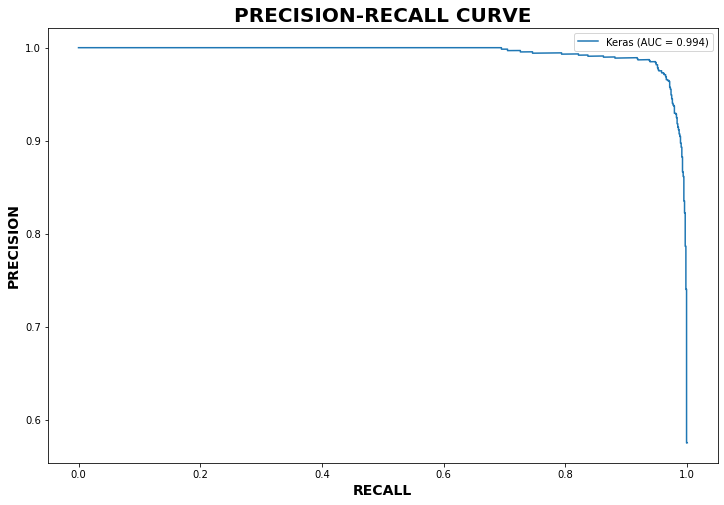

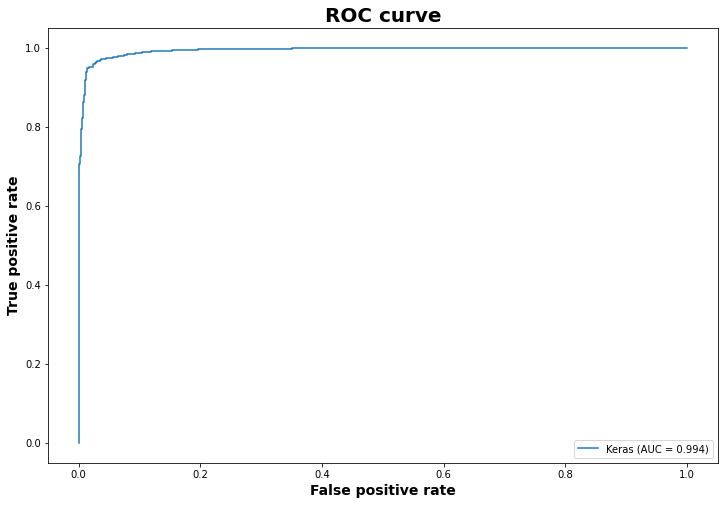

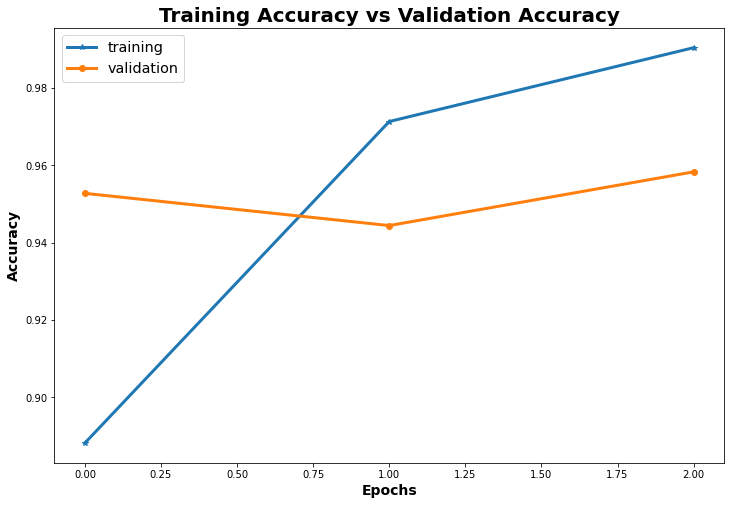

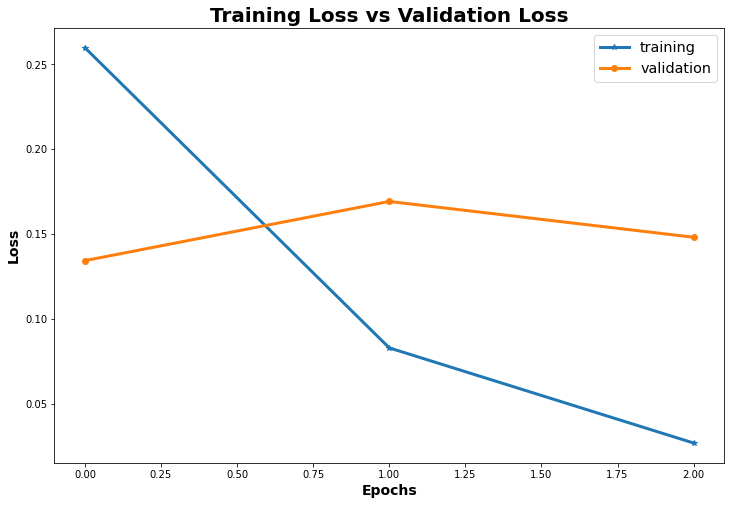

In [ ]:
model = performance_metrics(resnet)

#### VGG-19

Epoch 1/3
58/58 [==============================] - 4179s 72s/step - loss: 0.2045 - accuracy: 0.9236 - val_loss: 0.1302 - val_accuracy: 0.9611
Epoch 2/3
58/58 [==============================] - 4147s 72s/step - loss: 0.1300 - accuracy: 0.9554 - val_loss: 0.1310 - val_accuracy: 0.9618
Epoch 3/3
58/58 [==============================] - 4156s 72s/step - loss: 0.1091 - accuracy: 0.9641 - val_loss: 0.1144 - val_accuracy: 0.9611

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       899
           1       0.97      0.94      0.96       901

    accuracy                           0.96      1800
   macro avg       0.96      0.96      0.96      1800
weighted avg       0.96      0.96      0.96      1800




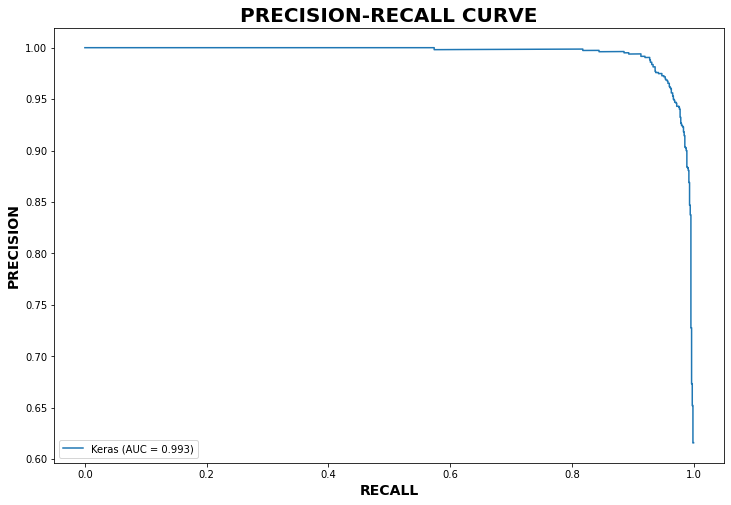

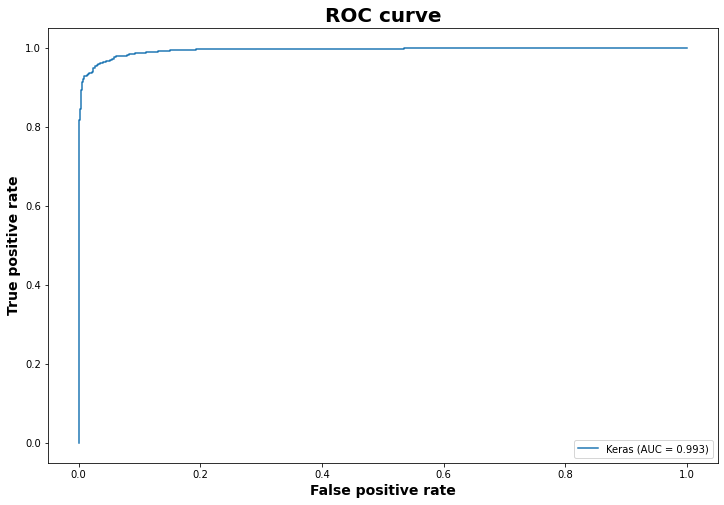

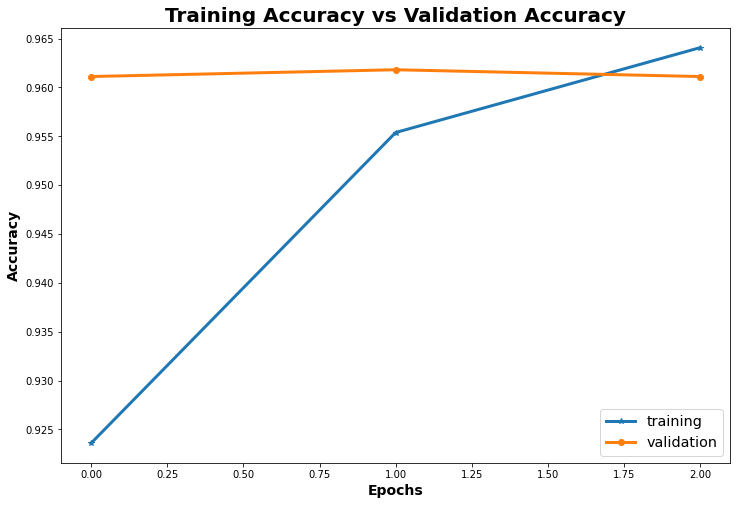

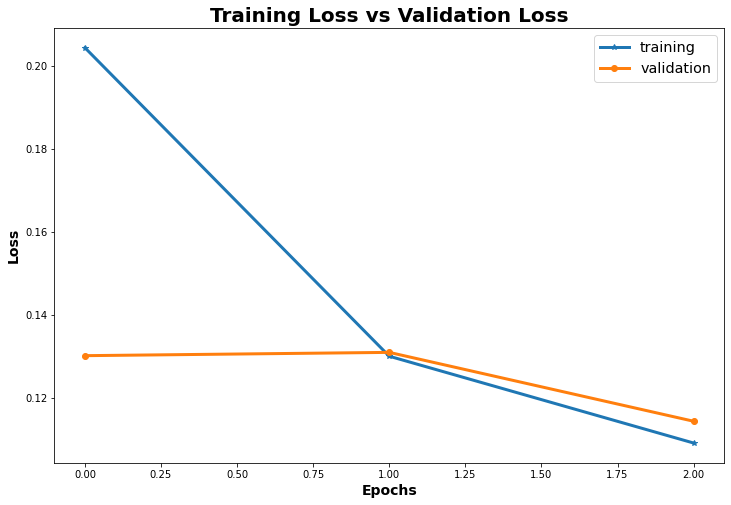

In [ ]:
model = performance_metrics(vgg)

#### Xception

83697664/83683744 [==============================] - 1s 0us/step
Epoch 1/3
58/58 [==============================] - 1901s 32s/step - loss: 0.3642 - accuracy: 0.8295 - val_loss: 0.4407 - val_accuracy: 0.8056
Epoch 2/3
58/58 [==============================] - 1891s 33s/step - loss: 0.1108 - accuracy: 0.9597 - val_loss: 0.2219 - val_accuracy: 0.9229
Epoch 3/3
58/58 [==============================] - 1873s 32s/step - loss: 0.0509 - accuracy: 0.9809 - val_loss: 0.1689 - val_accuracy: 0.9493

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       899
           1       0.97      0.94      0.95       901

    accuracy                           0.95      1800
   macro avg       0.95      0.95      0.95      1800
weighted avg       0.95      0.95      0.95      1800




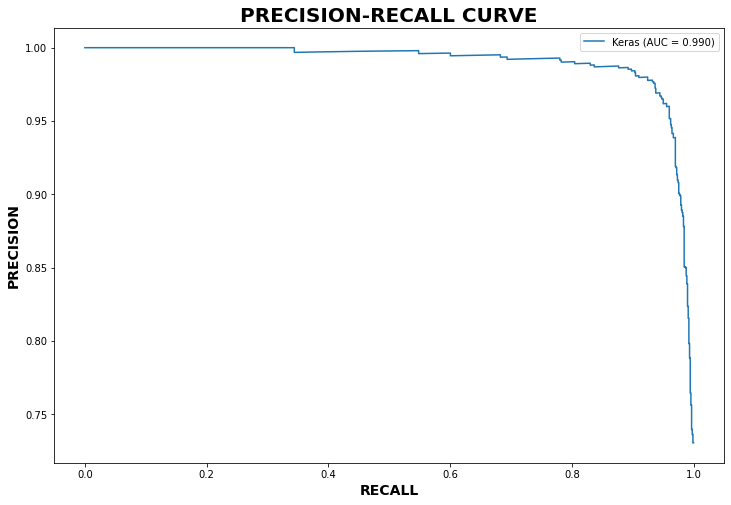

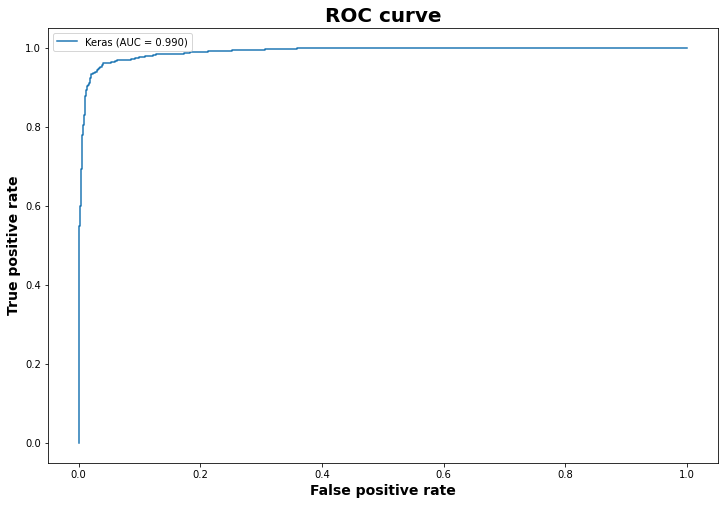

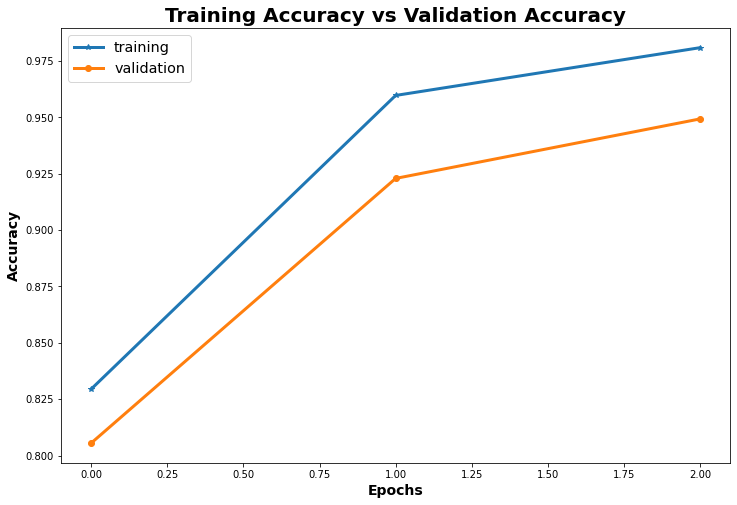

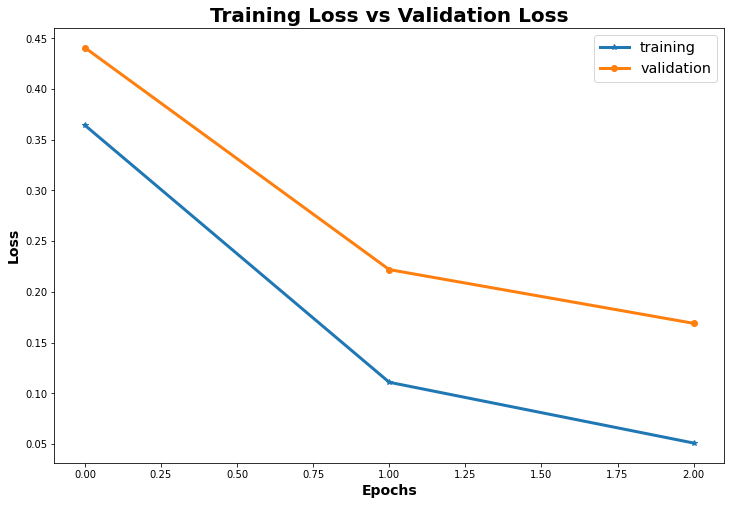

In [ ]:
model = performance_metrics(xception)

#### Inception

87924736/87910968 [==============================] - 1s 0us/step
Epoch 1/3
58/58 [==============================] - 1057s 18s/step - loss: 0.4343 - accuracy: 0.7844 - val_loss: 0.5842 - val_accuracy: 0.6264
Epoch 2/3
58/58 [==============================] - 1022s 18s/step - loss: 0.1570 - accuracy: 0.9438 - val_loss: 0.1672 - val_accuracy: 0.9389
Epoch 3/3
58/58 [==============================] - 1037s 18s/step - loss: 0.0812 - accuracy: 0.9738 - val_loss: 0.1877 - val_accuracy: 0.9306

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       899
           1       0.91      0.97      0.94       901

    accuracy                           0.93      1800
   macro avg       0.94      0.93      0.93      1800
weighted avg       0.94      0.93      0.93      1800




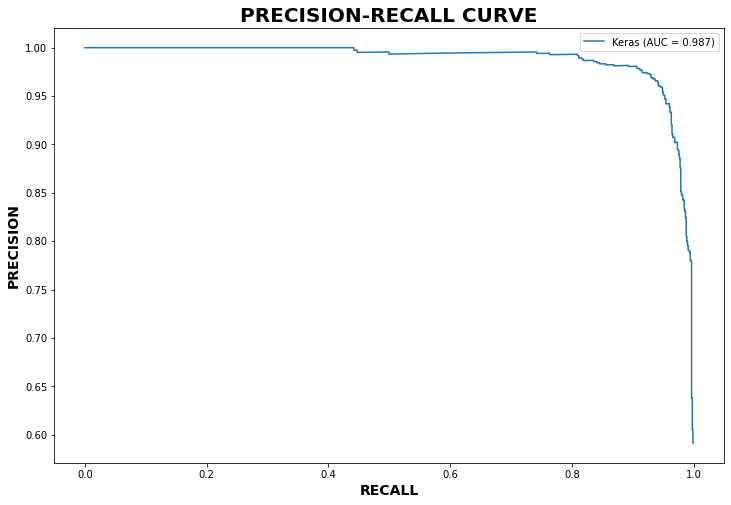

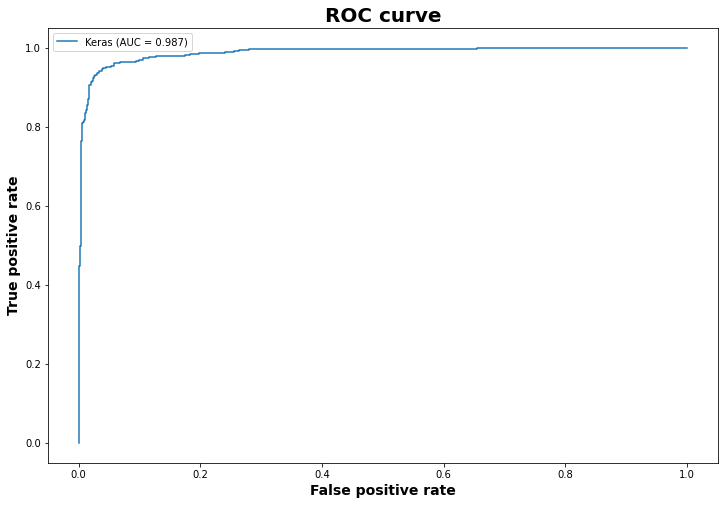

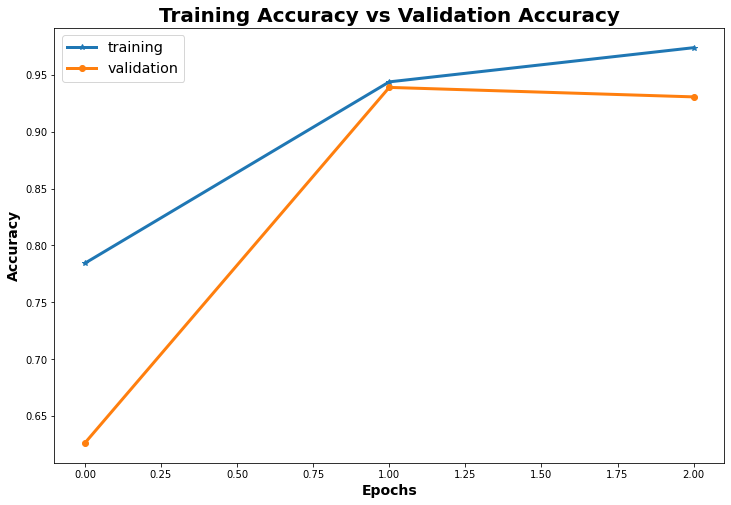

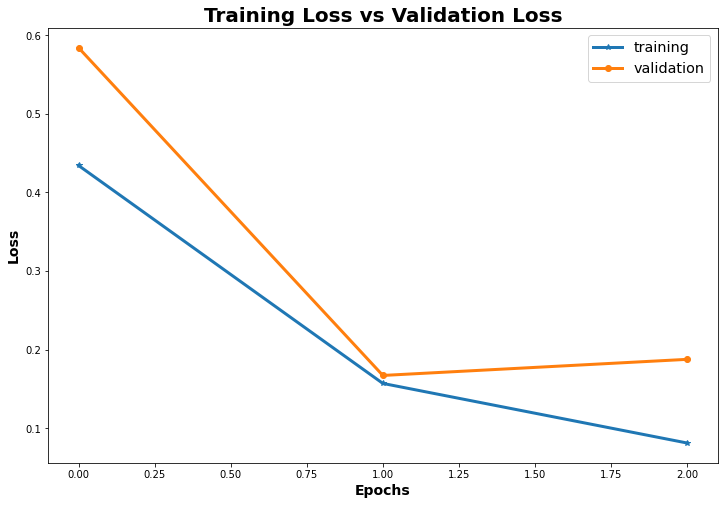

In [ ]:
model = performance_metrics(inception)

#### MobileNet-V2

Epoch 1/3
58/58 [==============================] - 328s 5s/step - loss: 0.3616 - accuracy: 0.8304 - val_loss: 2.0116 - val_accuracy: 0.4889
Epoch 2/3
58/58 [==============================] - 313s 5s/step - loss: 0.1328 - accuracy: 0.9524 - val_loss: 2.4427 - val_accuracy: 0.4889
Epoch 3/3
58/58 [==============================] - 313s 5s/step - loss: 0.0835 - accuracy: 0.9707 - val_loss: 2.5157 - val_accuracy: 0.4889

Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       899
           1       0.00      0.00      0.00       901

    accuracy                           0.50      1800
   macro avg       0.25      0.50      0.33      1800
weighted avg       0.25      0.50      0.33      1800



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


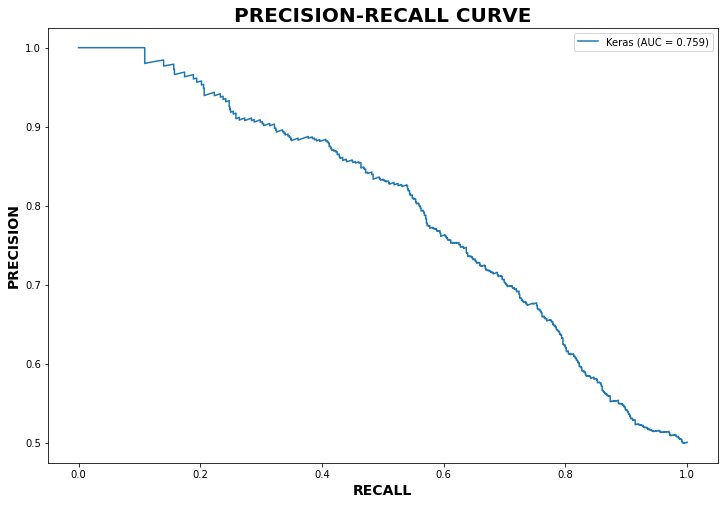

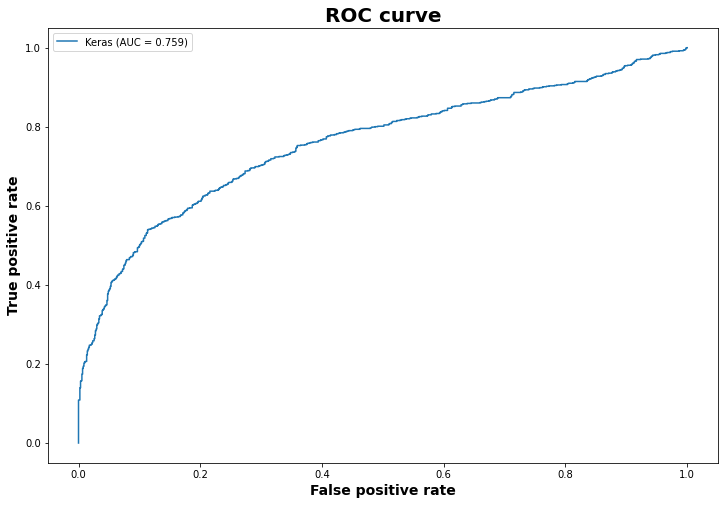

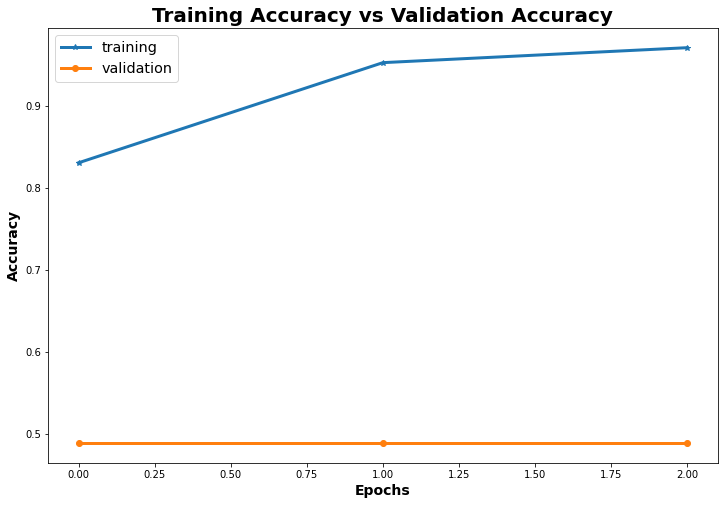

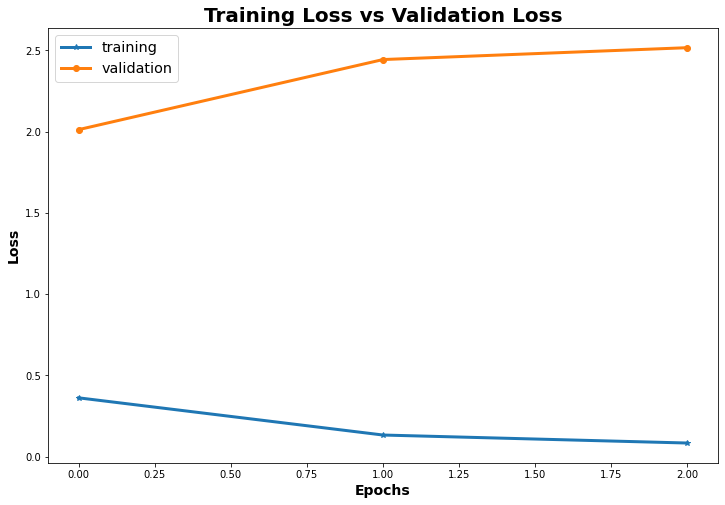

In [ ]:
model = performance_metrics(mobilenet)

#### **Fine-Tuning the best model (ResNet-50):**

In [5]:
model = Sequential()
model.add( resnet(include_top=False, pooling='avg', weights='imagenet', input_shape=(128, 128, 3), classes=2))
model.add(Flatten())
# ADDED A BATCHNORMALIZATION LAYER WITH SIGMOID ACTIVATION FUNCTION
model.add(BatchNormalization())                   
model.add(Activation('sigmoid'))
# ADDED A DROUPOUT LAYER WITH DROPOUT RATE = 30%
model.add(Dropout(0.3))  
# ADDED 2 DENSE LAYERS WITH SCLAED EXPONENTIAL LINEAR ACTIVATION FUNCTION                         
model.add(Dense(256,activation='selu'))           
model.add(Dense(64,activation='selu'))
# ADDED AN OUTPUT LAYER OF 1 UNIT WITH SIGMOID ACTIVATION FUNCTION
model.add(Dense(1,activation = 'sigmoid'))       
# SETTING ALL LAYERS EXCEPT LAST 10 LAYERS TO BE NON-TRAINABLE TO KEEP "Imagenet" WEIGHTS AND BIASES 
for layer in model.layers[:-10]:                  
  layer.trainable=False
early_stop = EarlyStopping(monitor='val_loss', patience=2)
# ADDING NADAM OPTIMIZER
opt = Nadam(learning_rate=0.00005, beta_1=0.9, beta_2=0.999, epsilon=1e-07)                            
model.compile(optimizer= opt, loss='binary_crossentropy', metrics=['accuracy'])
model_history = model.fit(X_train,y_train, validation_split = 0.2,epochs=3, batch_size=100, verbose=1)

94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/3
58/58 [==============================] - 1404s 24s/step - loss: 0.2819 - accuracy: 0.8752 - val_loss: 0.1760 - val_accuracy: 0.9319
Epoch 2/3
58/58 [==============================] - 1352s 23s/step - loss: 0.0796 - accuracy: 0.9715 - val_loss: 0.1284 - val_accuracy: 0.9597
Epoch 3/3
58/58 [==============================] - 1338s 23s/step - loss: 0.0294 - accuracy: 0.9905 - val_loss: 0.1504 - val_accuracy: 0.9583


#### **Let's plot some random images with their predicted class labels:**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00         9

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



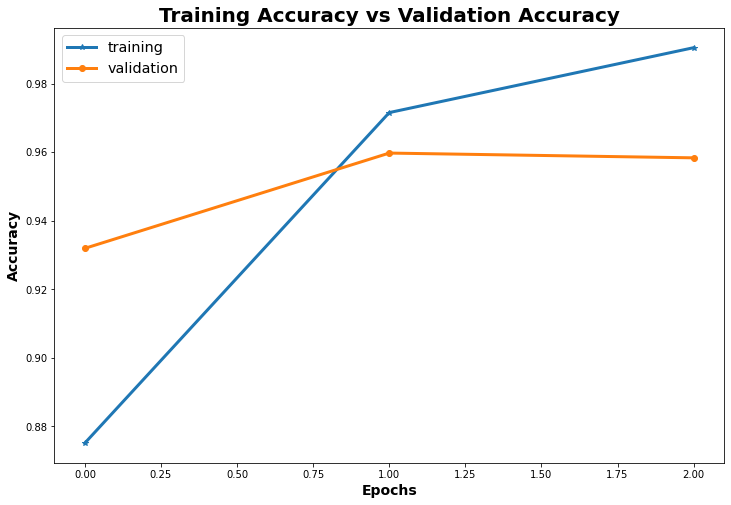

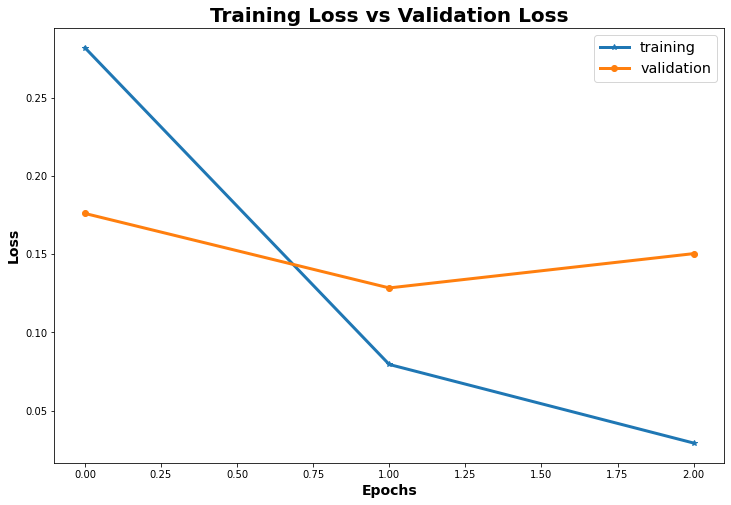

In [6]:
## Trying to plot random images with their predicted class labels:
x, y  = images_shuffled[:25], labels_shuffled[:25]
X = np.array(x)
X_test = np.array(X)
y_test = np.array(y)

y_pred_keras = model.predict(X_test).ravel()
y_pred_keras = model.predict(X_test).ravel()
y_pred = []
for item in y_pred_keras:
  if item > 0.5:
    item = 1
  else:
    item = 0
  y_pred.append(item)

## PLOTTING TRAINING ACCURACY AND VALIDATION ACCURACY:
plt.figure(figsize=(12,8))
plt.plot(model_history.history['accuracy'], label = 'training', marker = '*', linewidth = 3)
plt.plot(model_history.history['val_accuracy'], label = 'validation', marker = 'o', linewidth = 3)
plt.title('Training Accuracy vs Validation Accuracy', fontsize = 20, fontweight = 'bold')
plt.xlabel('Epochs', fontsize = 14, fontweight = 'bold')
plt.ylabel('Accuracy', fontsize = 14, fontweight = 'bold')
plt.legend(fontsize = 'x-large')

## PLOTTING TRAINING LOSS AND VALIDATION LOSS:
plt.figure(figsize=(12,8))
plt.plot(model_history.history['loss'], label = 'training', marker = '*', linewidth = 3)
plt.plot(model_history.history['val_loss'], label = 'validation', marker = 'o', linewidth = 3)
plt.title('Training Loss vs Validation Loss', fontsize = 20, fontweight = 'bold')
plt.xlabel('Epochs', fontsize = 14, fontweight = 'bold')
plt.ylabel('Loss', fontsize = 14, fontweight = 'bold')
plt.legend(fontsize = 'x-large')

print(classification_report(y_test, y_pred))

Text(204.36, 0.5, 'true label (ground truth)')

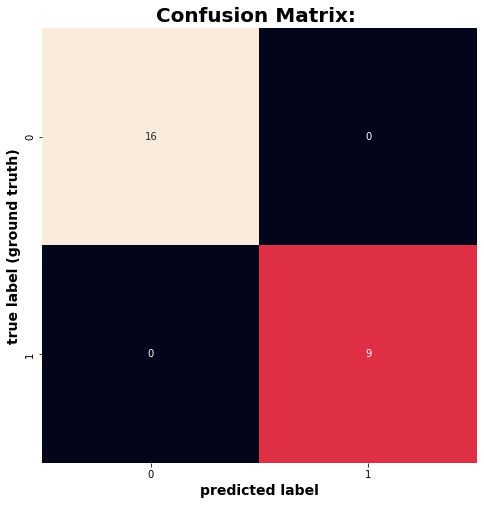

In [7]:
## PLOTTING CONFUSION MATRIX FOR OUR CNN CLASSIFIER:
plt.figure(figsize=(12,8))
matrix = confusion_matrix(y_test, y_pred)
plt.title('Confusion Matrix: ', fontsize = 20, fontweight = 'bold')
sns.heatmap(matrix, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('predicted label', fontsize = 14, fontweight = 'bold')
plt.ylabel('true label (ground truth)', fontsize = 14, fontweight = 'bold')

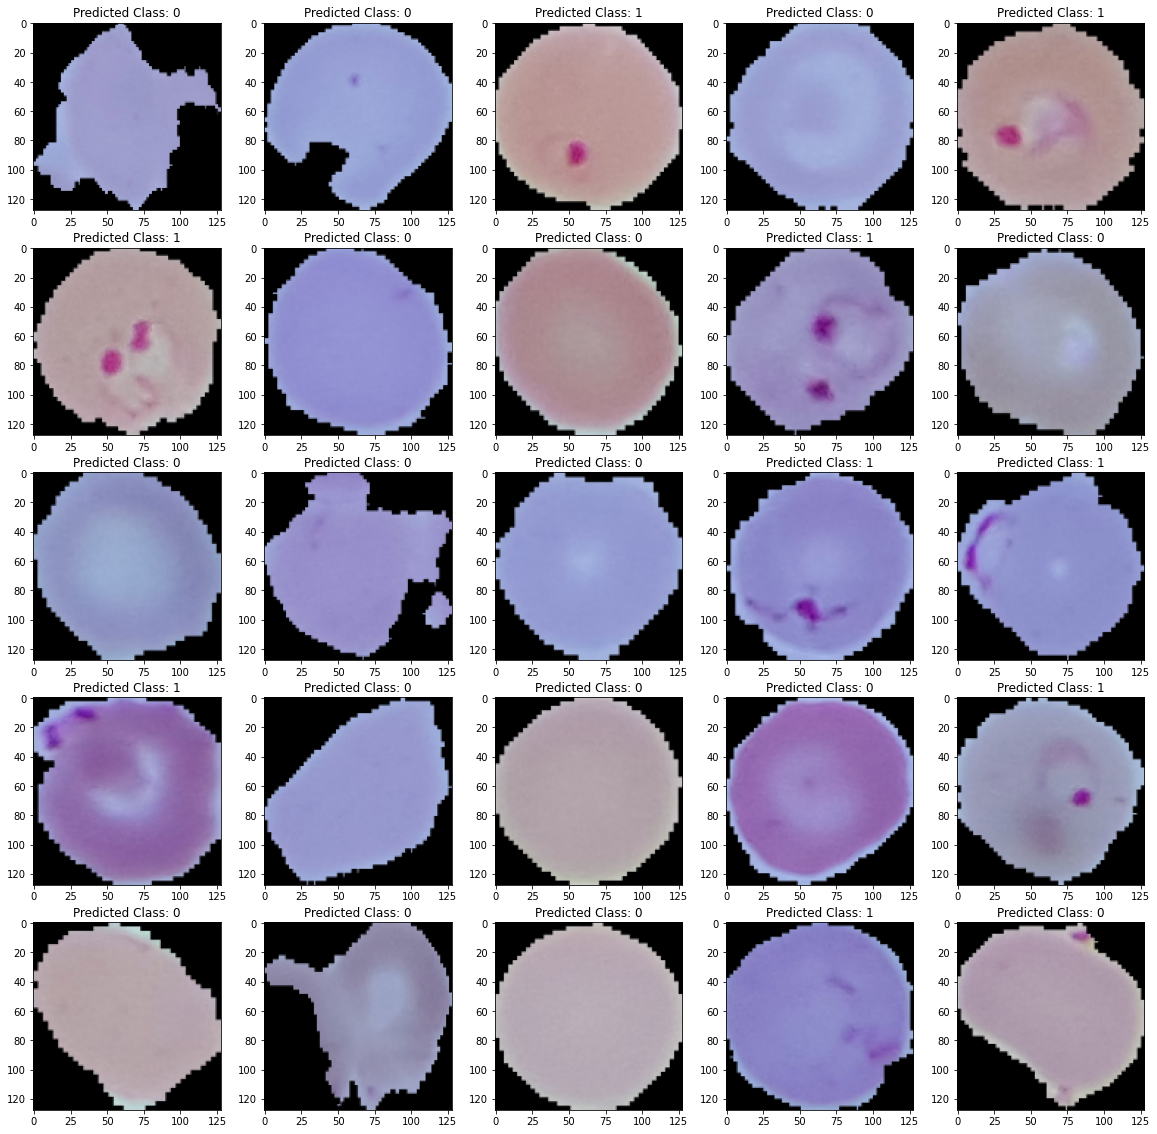

In [8]:
plt.figure(figsize=(20,20))
for i in range(25):
    plt.subplot(5,5,i+1).set_title('Predicted Class: {}'.format(y_pred[i]))
    plt.imshow(images_shuffled[i])

#### **Evaluation of the whole process and dicussion on what can be improved ?**

The orignal data had 27,598 images out of which only 9000 were used to create train and test sets as Google Colab was running out of runtime. Models used in this project were trained only for 3 epochs. Setting epochs = 10 and creating training and test set using all the images in the dataset might have resulted in more accuracy

Images were rescaled to 128 x 128 pixels. Training and Test sets were shuffled in order to ensure that it prevents bias and also prevents the model from learning the order of training so that it would generalise well on the test set and overfit less.

Since sigmoid is a special case of softmax activation function, the output layer of each model had only 1 artificial neural network with sigmoid activation function instead of 2 units with softmax activation so that it would update faster. 

Loss and accuracy changes abruptly in the first few iterations of the "training loss vs validation loss" and "training accuracy vs validation accuracy" plots, which indicates overfitting, but this overfitting is not severe. To reduce this overfitting, image augmentation should have been done. 

Note: Image augmentation should only be applied on train set and not on validation and test set. 

I have not used image augmentation in this project because it was increasing the size of training set by more than 20 times which resulted in " Out of runtime error ". Also Image Augmentation can only be applied to images and not to arrays. If we used augmented images instead of arrays of images, we wouldn't have acces to it's labels and we would not have been able to calculate it's accuracy. Augmentation works well with multi-class classification tasks but is not very recommended for binary classification tasks where classification reports (F1, Precision, Recall, AUC, ROC) needs to be calculated.

All layers except the last 10 layers were set to be Non-Trainable so that they would retain "Imagenet" weights and biases. Since our models used Imagenet weights, biases and parameters to achieve more than 97% accuracy and 99.4% AUC, it can be claimed that this binary classification task of identifying parasited Images is very similar to Imagenet. 

I got 97% accuracy in just 3 epochs because I used BatchNormalisation layer and 30% dropout. Tweaking and playing around with the number of epochs and dropout rate may get us better accuracy

Selection of best model:

VGG-19 and ResNet-50 performed almost identically with F1 score of 0.96 and 0.97 respectfully and AUC score of 0.993 and 0.994 respectfully; But looking at the "Training Accuracy vs Validation Accuracy" and "Training Loss vs Validation Loss" curves we can observe that VGG-19 underfits less than ResNet-50 and generalizes slightly better at the validation data. ResNet-50 has slightly better recall than VGG-19 and is computationally less expensive (runs faster). So all these factors made me choose ResNet-50 over VGG-19

Also, it is quite explicit from the  "Training Accuracy vs Validation Accuracy" and "Training Loss vs Validation Loss" curves that MobileNet-V2 suffers from extreme underfitting which explains why it performs much poorly as compared to other models used in this project

